In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import pickle

## Warmup

In [2]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

data = sample_data()
train, test = train_test_split(data, train_size=0.8)
test = torch.tensor(test)

In [3]:
def compute_loss(thetas, data):
    exps = torch.exp(thetas)
    all_probs = exps / torch.sum(exps)
    probs = torch.gather(all_probs, 0, data)
    return -torch.sum(torch.log2(probs)) 

In [4]:
thetas = torch.zeros(100, requires_grad=True)
optimizer = torch.optim.Adam([thetas])

batch_sise = 200
num_epochs = 200
train_batches = torch.utils.data.DataLoader(train, batch_size=batch_sise, shuffle=True) 

In [5]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    loss = 0
    for batch in train_batches:
        optimizer.zero_grad()
        cur_loss = compute_loss(thetas, batch)
        loss += cur_loss.item()
        cur_loss.backward()
        optimizer.step()

    train_losses.append(loss / len(train))
    val_losses.append(compute_loss(thetas, test) / len(test))
    if epoch % 20 == 0:
        print(f'Epoch {epoch}: training loss {train_losses[-1]}, validation loss {val_losses[-1]}')


Epoch 0: training loss 6.623132125854492, validation loss 6.6014180183410645
Epoch 20: training loss 6.093688613891602, validation loss 6.089169025421143
Epoch 40: training loss 5.920217239379883, validation loss 5.925217151641846
Epoch 60: training loss 5.864775833129883, validation loss 5.874048233032227
Epoch 80: training loss 5.843584609985352, validation loss 5.854781627655029
Epoch 100: training loss 5.833597015380859, validation loss 5.8458685874938965
Epoch 120: training loss 5.828354568481445, validation loss 5.841370105743408
Epoch 140: training loss 5.825484405517578, validation loss 5.83897590637207
Epoch 160: training loss 5.823785446166992, validation loss 5.837679386138916
Epoch 180: training loss 5.8228240509033204, validation loss 5.836921691894531


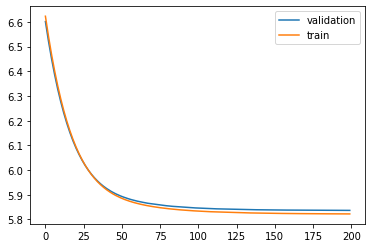

In [6]:
plt.plot(np.arange(num_epochs), val_losses)
plt.plot(np.arange(num_epochs), train_losses)
plt.legend(('validation','train'));

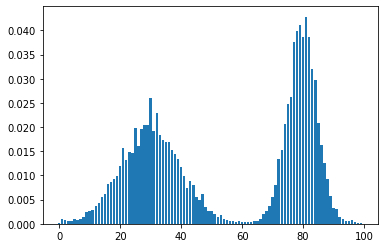

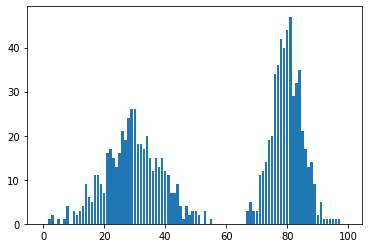

In [7]:
probs = (torch.exp(thetas) / torch.sum(torch.exp(thetas))).detach().numpy()
plt.figure(1)
plt.bar(np.arange(100), probs)
plt.figure(2)
plt.bar(np.arange(100), np.histogram(data[:1000], bins=100, range=(0,100))[0]);

## Two-dimensional data

In [3]:
distribution = np.load('distribution.npy')

In [4]:
pairs = np.indices(dimensions=(200,200)).T 
n = 100000
inds = np.random.choice(np.arange(200 ** 2), p=distribution.reshape(-1), size=n)
selections = pairs.reshape(-1, 2)[inds]
train, test = train_test_split(selections, train_size=0.8)

In [46]:
class TwoDPrediction(torch.nn.Module):

    MAX_NUMBER = 200
    
    def __init__(self):
        super(TwoDPrediction, self).__init__()

        self.linear = torch.nn.Linear(self.MAX_NUMBER, 200)
        self.out = torch.nn.Linear(200, self.MAX_NUMBER)
        self.softmax = torch.nn.Softmax(dim=1)
        
        self.thetas = torch.nn.Parameter(torch.ones(self.MAX_NUMBER))
    
    def forward(self, X):
        x, y = X[:, 0], X[:, 1]
        x_prob = torch.exp(self.thetas[x]) / torch.sum(torch.exp(self.thetas))
        
        y_onehot = torch.nn.functional.one_hot(y, num_classes=self.MAX_NUMBER).float()
        
        z1 = self.linear(y_onehot).clamp(min=0)
        z2 = self.out(z1)
#         print(z2.shape)
        z = self.softmax(z2)
        
        y_probs = torch.gather(z, 1, x.view(-1, 1)).view(-1)

#         print(y_probs.sum())
        return x_prob * y_probs
    
def get_loss(outputs):
    return -torch.sum(torch.log2(outputs))

In [48]:
model = TwoDPrediction()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# print(list(model.parameters()))
# raise ValueError(1)
train_losses = []
val_losses = []

batch_sise = 500
num_epochs = 20
train_batches = torch.utils.data.DataLoader(train, batch_size=batch_sise, shuffle=True) 
test = torch.tensor(test)

for epoch in range(num_epochs):
    loss = 0
    for batch in train_batches:
        optimizer.zero_grad()
        outputs = model(batch)
        cur_loss = get_loss(outputs)
        loss += cur_loss.item()
        cur_loss.backward()
        optimizer.step()

    train_losses.append(loss / len(train))
    val_losses.append(get_loss(model(test)) / len(test))
    
    print(f'Epoch {epoch}: training loss {train_losses[-1]}, validation loss {val_losses[-1]}')

//miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Epoch 0: training loss 15.282784051513671, validation loss 15.277693748474121
Epoch 1: training loss 15.270593334960937, validation loss 15.267364501953125
Epoch 2: training loss 15.258113623046874, validation loss 15.257257461547852
Epoch 3: training loss 15.246458422851562, validation loss 15.249216079711914
Epoch 4: training loss 15.237484075927734, validation loss 15.2442626953125
Epoch 5: training loss 15.23144395751953, validation loss 15.241381645202637
Epoch 6: training loss 15.227222723388671, validation loss 15.239429473876953
Epoch 7: training loss 15.223722436523438, validation loss 15.237690925598145
Epoch 8: training loss 15.220547058105469, validation loss 15.235976219177246
Epoch 9: training loss 15.217449914550782, validation loss 15.234428405761719
Epoch 10: training loss 15.214455194091796, validation loss 15.23295783996582
Epoch 11: training loss 15.211454095458985, validation loss 15.23145580291748
Epoch 12: training loss 15.208500457763671, validation loss 15.2300

In [ ]:
plt.plot(np.arange(num_epochs), val_losses)
plt.plot(np.arange(num_epochs), train_losses)
plt.legend(('validation','train'));

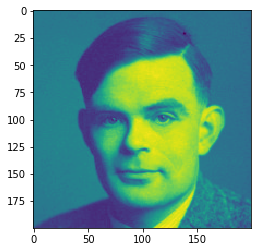

In [20]:
plt.imshow(distribution);

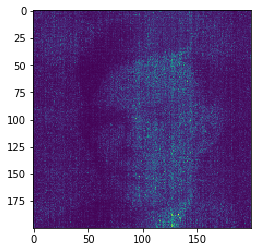

In [39]:
predicted = model(torch.tensor(pairs.reshape(-1, 2))).reshape(200, 200)
plt.imshow(predicted.detach().numpy());

In [21]:
class MaskedLayer(torch.nn.Linear):
    def __init__(self, in_features, out_features, mask):
        super().__init__(in_features, out_features, bias=True)    
        self.mask = torch.tensor(mask).float()
    
    def forward(self, x):
        return torch.functional.F.linear(x, self.weight * self.mask, self.bias)

In [22]:
class MADE(torch.nn.Module):
    def __init__(self):
        super(MADE, self).__init__()

        self.size = 400
        
        m_0 = np.random.permutation(np.arange(1, self.size + 1))
        m_1 = np.random.uniform(1, self.size, self.size)
        M_0 = m_0[:, None] <= m_1[None, :]
        M_1 = m_1[:, None] < m_0[None, :]
        
        lin1 = MaskedLayer(self.size, self.size, M_0)
        lin2 = MaskedLayer(self.size, self.size, M_1)
        
        self.net = torch.nn.Sequential(
            lin1,
            torch.nn.ReLU(),
            lin2
        )
        self.softmax = torch.nn.Softmax(dim=2)

    def forward(self, X):
        x, y = X[:, 0], X[:, 1]
        
        n = X.shape[0]
        onehot = np.zeros((n, 400), dtype='float32')
        onehot[np.arange(n), x] = 1
        onehot[np.arange(n), y + 200] = 1
        onehot = torch.from_numpy(onehot).float()
        output = self.net(onehot).view(-1, 2, 200)
        output = self.softmax(output).view(-1, 400)
        indices = np.arange(n)
        res = output[indices, x[indices]] * output[indices, 200 + y[indices]]
        return res

In [28]:
model = MADE()
optimizer = torch.optim.Adam(model.parameters())

train_losses = []
val_losses = []

batch_sise = 1000
num_epochs = 200

for epoch in range(num_epochs):
    loss = 0
    for batch in train_batches:
        optimizer.zero_grad()
        outputs = model(batch)
        cur_loss = get_loss(outputs)
        loss += cur_loss.item()
        cur_loss.backward()
        optimizer.step()

    train_losses.append(loss / len(train))
    val_losses.append(get_loss(model(test)) / len(test))
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: training loss {train_losses[-1]}, validation loss {val_losses[-1]}')

Epoch 0: training loss 1.1433322326660156, validation loss 1.5391955375671387
Epoch 5: training loss 1.1201272201538086, validation loss 1.5266363620758057
Epoch 10: training loss 1.1045433349609375, validation loss 1.5105466842651367
Epoch 15: training loss 1.0981847045898439, validation loss 1.5073912143707275
Epoch 20: training loss 1.087661798095703, validation loss 1.506283164024353
Epoch 25: training loss 1.0854856948852538, validation loss 1.5031167268753052
Epoch 30: training loss 1.069179899597168, validation loss 1.4927246570587158
Epoch 35: training loss 1.0658191955566407, validation loss 1.490873098373413
Epoch 40: training loss 1.0578549270629882, validation loss 1.4875402450561523
Epoch 45: training loss 1.0516597885131835, validation loss 1.4966520071029663


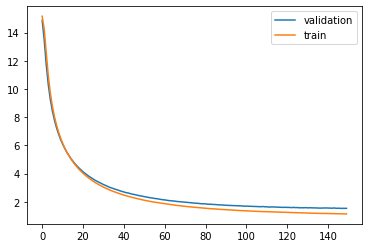

In [26]:
plt.plot(np.arange(num_epochs), val_losses)
plt.plot(np.arange(num_epochs), train_losses)
plt.legend(('validation','train'));

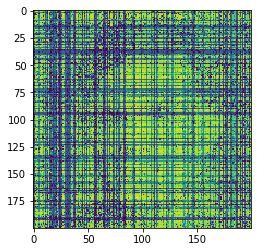

In [29]:
predicted = model(pairs.reshape(-1, 2)).reshape(200, 200)
plt.imshow(predicted.detach().numpy());